# Benchmarking Emotion Recognition

In this notebook we perform the benchmarking of our emotion detection models. In particular, we will track two metrics:
* weighted average precision
* average prediction time

In order to perform the benchmarking we selected 1000 random images from the test set, feeded them into the various models and computed the two metrics above. 

We have decided to track weighted average precision for benchmarking our models against each other. The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. It is the fraction of events where the classifier correctly declared class i out of all instances where the classifier declared class i. Since our benchmarking dataset is imbalanced, we calculate the precision for each label and then find their average weighted by support, which is the number of true instances for each label. For balanced datasets, the weighted average precision is equal to average precision.

Depending on the final implementation of our application, the prediction time of the model is also of relevance. Therefore, we test how fast each model outputs a prediction on average (in seconds). We are aware, that depending on the available computing power, prediction time may vary significantly. Yet, we are interested in the relative performance of our implemented models.

In [10]:
# import libraries
import random, os
import time
import shutil
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score, average_precision_score, balanced_accuracy_score, classification_report

# set image target Size
IMG_HEIGHT = 96
IMG_WIDTH = 96 

In [11]:
# Set directory paths relative to facial_expression_full folder: 

#only modify the facial_exp_dir variable such that the path reaches the folder facial_expression_full
facial_exp_dir = "/Users/Felix/datasets/facial_expression_full/"

#There is no need to modify the dependencies below. 

#Set Paths to models and weights: 

##
#Models with architectures and weights in two different files: 
##
# facial_expression_full/models_and_weights/sep_models/"
model_dir = facial_exp_dir + "models_and_weights/sep_models/"

##
#Models with architectures and weights in the same file: 
##
# facial_expression_full/Models_and_Weights/full_models/"
models_p_directory = facial_exp_dir + "models_and_weights/full_models/"

##
#Set path to benchmarking directory
##
# facial_expression_full/benchmarking/"
benchmark_dir = facial_exp_dir + "benchmarking/"

##
#Set the directory for test images for benchmarking: 
##
# facial_expression_full/benchmarking/test_images/"
input_dir = facial_exp_dir + "benchmarking/test_images/"


In [12]:
# open the small test df 
small_benchmak_df = pd.read_csv(benchmark_dir +'small_benchmak_df')
small_benchmak_df = small_benchmak_df[['image_name', 'label']]
small_benchmak_df.head()

,image_name,label
0,crying_African_244_0.png,4
1,fer0017590.png,3
2,fer0018106.png,1
3,fer0015716.png,2
4,astound_soldier_794_5.png,2


In [4]:
# create a dictionaty mapping the image name with the numerically labeled emotion
name_to_label_dict = pd.Series(small_benchmak_df.label.values,index=small_benchmak_df.image_name).to_dict()

In [16]:
# create a function to decode and resize images
def decode_and_resize(image_name):
    image = tf.io.read_file(input_dir + image_name)
    image = tf.image.decode_image(image, channels=3, dtype="uint8")
    image = tf.image.per_image_standardization(image) 
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return tf.cast(image, tf.float32) / 255.0

In [17]:
# create a class for managing the models having architectures and weights in two different files
class FacialExpressionModel(object):
    
    EXPRESSIONS_LIST_NUMERIC = [i for i in range(1,8)]
    
    def __init__(self, model_json_file, model_weights_file):
        
         # initite an empty list where to store the predictions
        self.predictions = []
        self.prediction_times = []
        self.average_time=0
        self.weighted_average_precision=0
        
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        
    def predict_emotion(self, img):
        # get starting time
        start_time = time.time()
        # obtain the probability of each emotion
        self.preds_probability = self.loaded_model.predict(img)
        # get finishing time
        finish_time = time.time()
        # compute the prediction time
        pred_time = finish_time - start_time
        #append the prediction time
        self.prediction_times.append(pred_time)
        # obtain the label associated with the highest probability
        pred = self.EXPRESSIONS_LIST_NUMERIC[np.argmax(self.preds_probability)]
        # append the current prediction to the prediction list
        self.predictions.append(pred)
        
    def compute_weighted_average_precision(self, y_true, y_pred):
        weighted_average_precision= classification_report(y_true, y_pred, output_dict=True)['weighted avg']['precision']
        self.weighted_average_precision  = weighted_average_precision
        return weighted_average_precision
        
    def compute_avg_prediction_time(self):
        avg_prediction_time = sum(self.prediction_times)/ len(self.prediction_times)
        self.average_time = avg_prediction_time
        return avg_prediction_time

In [22]:
# create a class for managing the models having architectures and weights in the same files
class FER_Models(object):
    
    EXPRESSIONS_LIST_NUMERIC = [i for i in range(1,8)]
    
    def __init__(self, model_weights_file):
        
         # initite an empty list where to store the predictions
        self.predictions = []
        self.prediction_times = []
        self.average_time=0
        self.weighted_average_precision=0

        # load weights into the new model
        self.loaded_model = load_model(model_weights_file)
        
    def predict_emotion(self, img):
        # get starting time
        start_time = time.time()
        # obtain the probability of each emotion
        self.preds_probability = self.loaded_model.predict(img)
        # get finishing time
        finish_time = time.time()
        # compute the prediction time
        pred_time = finish_time - start_time
        #append the prediction time
        self.prediction_times.append(pred_time)
        # obtain the label associated with the highest probability
        pred = self.EXPRESSIONS_LIST_NUMERIC[np.argmax(self.preds_probability)]
        # append the current prediction to the prediction list
        self.predictions.append(pred)
        
        #return FacialExpressionModel.EXPRESSIONS_LIST[np.argmax(self.preds)], self.preds_probability
        
    def compute_weighted_average_precision(self, y_true, y_pred):
        weighted_average_precision= classification_report(y_true, y_pred, output_dict=True)['weighted avg']['precision']
        self.weighted_average_precision  = weighted_average_precision
        return weighted_average_precision
        
    def compute_avg_prediction_time(self):
        avg_prediction_time = sum(self.prediction_times)/ len(self.prediction_times)
        self.average_time = avg_prediction_time
        return avg_prediction_time

## Benchmark of the models loaded from json files

In [74]:
# obtain a list of all the models and the associated weights
os.listdir(model_dir)

['resnet152V2.h5',
 'resnet152V2_model.json',
 'resnet_50_75e.h5',
 'resnet_50_model.json',
 'xception_35evaluation.h5',
 'xception_model.json',
 'xception_tl_ft.h5',
 'xception_tl_ft_model.json',
 'xception_tl_model.json',
 '.ipynb_checkpoints']

In [19]:
# create a dictionary in which to store the relavent metrics
# the structure will be: performance_dict["model_name"] = [weighted_average_precision, average_time]
performance_dict = dict()

# create a list where to store the model_names and the model weights
models = [
    ['resnet_50_model.json', 'resnet_50_75e.h5'],
    ['resnet152V2_model.json','resnet152V2.h5'],
    ['xception_model.json','xception_35evaluation.h5'],
    ['xception_tl_ft_model.json','xception_tl_ft.h5']  
]

In [36]:
# iterate over the models
for model in models:
    # load the model structure and its weights
    print('loading {}'.format(model[0].split(".")[0]))
    current_model = FacialExpressionModel(model_dir + model[0], model_dir + model[1])
    print("model loaded")
    
    print('getting the predictions')
    # get the prediction for all 1000 testing images
    for k,v in name_to_label_dict.items():
        # load the image
        img_deco = decode_and_resize(k)

        # reshape as a fake batch 
        img_input = tf.expand_dims(img_deco, axis=0)

        # get the prediction
        current_model.predict_emotion(img_input)
    print('predictions done')
        
    # compute the weighted_average_precision for the current model
    print("computing the weighted average precision of {}".format(model[0].split(".")[0]))
    current_model.compute_weighted_average_precision(list(name_to_label_dict.values()), current_model.predictions)

    # compute the average time it takes to make the prediction
    print("computing the average prediction time of {}".format(model[0].split(".")[0]))
    current_model.compute_avg_prediction_time()
    
    # add the previous score to the performance_dict
    performance_dict[model[0].split(".")[0]] = [current_model.weighted_average_precision, current_model.average_time]
    print()

loading resnet_50_model
model loaded
getting the predictions
predictions done
computing the weighted average precision of resnet_50_model
computing the average prediction time of resnet_50_model

loading resnet_50_tl_model
model loaded
getting the predictions
predictions done
computing the weighted average precision of resnet_50_tl_model
computing the average prediction time of resnet_50_tl_model

loading resnet152V2_model
model loaded
getting the predictions
predictions done
computing the weighted average precision of resnet152V2_model
computing the average prediction time of resnet152V2_model

loading xception_model
model loaded
getting the predictions
predictions done
computing the weighted average precision of xception_model
computing the average prediction time of xception_model

loading xception_tl_ft_model
model loaded
getting the predictions
predictions done
computing the weighted average precision of xception_tl_ft_model
computing the average prediction time of xception_tl_ft_

In [66]:
# check the performance dictonary 
performance_dict

{'resnet_50_model': [0.599479527115729, 0.27765147948265073],
 'resnet152V2_model': [0.5734880351966888, 0.41249992537498475],
 'xception_model': [0.597263020443714, 0.30021450996398924],
 'xception_tl_ft_model': [0.5151578707494016, 0.32886655640602114]}

## Benchmark of the remaining models loaded from .h5 files

In [55]:
# get a list of the models having both the architecture and the weights in the same file
models_p = []
for file in os.listdir(models_p_directory):
    extension = file.split(".")[-1]
    if extension == "h5" or extension == "hdf5":
        models_p.append(file)
models_p

['inception_model_1_FD.h5',
 'naive_inception_model_1_FD.h5',
 'VGG16_model_FD.h5',
 'VGG_Inception_1_FD.h5',
 'VGG_model_1_FD.h5',
 'VGG_model_2_FD.h5',
 'ResNet50_TL_FT.hdf5']

From the above list we will remove the naive_inception_model_1_FD and the VGG16_model_FD because they performed rather poorly during training. 

In [56]:
models_p.remove("naive_inception_model_1_FD.h5")
models_p.remove("VGG16_model_FD.h5")
models_p

['inception_model_1_FD.h5',
 'VGG_Inception_1_FD.h5',
 'VGG_model_1_FD.h5',
 'VGG_model_2_FD.h5',
 'ResNet50_TL_FT.hdf5']

In [57]:
# iterate over the models
performance_dict_p = dict()

for model in models_p:
    # load the model structure and its weights
    print('loading {}'.format(model))
    current_model = FER_Models(models_p_directory + model)
    print("model loaded")
    
    print('getting the predictions')
    # get the prediction for all 1000 testing images
    for k,v in name_to_label_dict.items():
        # load the image
        img_deco = decode_and_resize(k)

        #reshape as a fake batch 
        img_input = tf.expand_dims(img_deco, axis=0)

        # get the prediction
        current_model.predict_emotion(img_input)
    print('predictions done')
        
    # compute the weighted_average_precision for the current model
    print("computing the weighted average precision of {}".format(model))
    current_model.compute_weighted_average_precision(list(name_to_label_dict.values()), current_model.predictions)

    # compute the average time it takes to make the prediction
    print("computing the average prediction time of {}".format(model))
    current_model.compute_avg_prediction_time()
    
    # add the previous score to the performance_dict
    performance_dict_p[model] = [current_model.weighted_average_precision, current_model.average_time]
    print()

loading inception_model_1_FD.h5
model loaded
getting the predictions
predictions done
computing the weighted average precision of inception_model_1_FD.h5
computing the average prediction time of inception_model_1_FD.h5

loading VGG_Inception_1_FD.h5
model loaded
getting the predictions
predictions done
computing the weighted average precision of VGG_Inception_1_FD.h5
computing the average prediction time of VGG_Inception_1_FD.h5

loading VGG_model_1_FD.h5
model loaded
getting the predictions
predictions done
computing the weighted average precision of VGG_model_1_FD.h5
computing the average prediction time of VGG_model_1_FD.h5

loading VGG_model_2_FD.h5
model loaded
getting the predictions
predictions done
computing the weighted average precision of VGG_model_2_FD.h5
computing the average prediction time of VGG_model_2_FD.h5

loading ResNet50_TL_FT.hdf5
model loaded
getting the predictions
predictions done
computing the weighted average precision of ResNet50_TL_FT.hdf5
computing the av

In [77]:
# check the performance dictonary
performance_dict_p

{'inception_model_1_FD.h5': [0.4562538960363645, 0.24310603976249695],
 'VGG_Inception_1_FD.h5': [0.5249140183397178, 0.22430579900741576],
 'VGG_model_1_FD.h5': [0.4978514525761788, 0.22617317914962767],
 'VGG_model_2_FD.h5': [0.5429461955085444, 0.2309540946483612],
 'ResNet50_TL_FT.hdf5': [0.5645912324122788, 0.28026635384559634]}

In [69]:
# merge the 2 performance dictionaries 
performance_dict_combined = {**performance_dict, **performance_dict_p}
performance_dict_combined

{'resnet_50_model': [0.599479527115729, 0.27765147948265073],
 'resnet152V2_model': [0.5734880351966888, 0.41249992537498475],
 'xception_model': [0.597263020443714, 0.30021450996398924],
 'xception_tl_ft_model': [0.5151578707494016, 0.32886655640602114],
 'inception_model_1_FD.h5': [0.4562538960363645, 0.24310603976249695],
 'VGG_Inception_1_FD.h5': [0.5249140183397178, 0.22430579900741576],
 'VGG_model_1_FD.h5': [0.4978514525761788, 0.22617317914962767],
 'VGG_model_2_FD.h5': [0.5429461955085444, 0.2309540946483612],
 'ResNet50_TL_FT.hdf5': [0.5645912324122788, 0.28026635384559634]}

In [78]:
# clean the model names
performance_dict_combined_clean = {'resnet50': [0.599479527115729, 0.27765147948265073],
                                   'resnet152V2': [0.5734880351966888, 0.41249992537498475],
                                   'xception': [0.597263020443714, 0.30021450996398924],
                                   'xception tl': [0.5151578707494016, 0.32886655640602114],
                                   'inception': [0.4562538960363645, 0.24310603976249695],
                                   'VGG Inception': [0.5249140183397178, 0.22430579900741576],
                                   'VGG v1': [0.4978514525761788, 0.22617317914962767],
                                   'VGG v2': [0.5429461955085444, 0.2309540946483612],
                                   'ResNet50 TL': [0.5645912324122788, 0.28026635384559634]}

# Benchmarking Results

<ipython-input-79-8e7e8b63c0a0>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


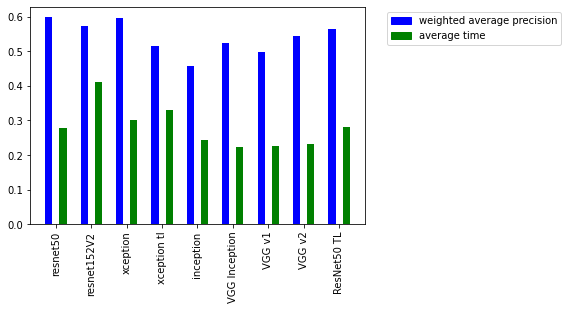

In [79]:
# plot the results
keys = [key for key in performance_dict_combined_clean.keys()]
values = [value for value in performance_dict_combined_clean.values()]

fig, ax = plt.subplots()

ax.bar(np.arange(len(keys)) - 0.2, [value[0] for value in values],
       width=0.2, color='b', align='center')

ax.bar(np.arange(len(keys)) + 0.2,
       [value[1] if len(value) == 2 else 0 for value in values],
       width=0.2, color='g', align='center')

ax.set_xticklabels(keys)
ax.set_xticks(np.arange(len(keys)))
plt.xticks(rotation=90)

colors = {'weighted average precision':'blue', 'average time':'green'}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

As we can see from the barplot above, ResNet50 is the model that achieves the highes weighted average precision while still keeping the average prediction time under 0.3 seconds.

In [80]:
# create a dataframe and export the data
performance_df=pd.DataFrame.from_dict(performance_dict_combined_clean,orient='index')
# add the columsn names
performance_df.columns = ["weighted average precision", "average time"]
performance_df

,weighted average precision,average time
resnet50,0.599480,0.277651
resnet152V2,0.573488,0.412500
xception,0.597263,0.300215
xception tl,0.515158,0.328867
inception,0.456254,0.243106
VGG Inception,0.524914,0.224306
VGG v1,0.497851,0.226173
VGG v2,0.542946,0.230954
ResNet50 TL,0.564591,0.280266


In [81]:
# export data to csv file
performance_df.to_csv(benchmark_dir + 'models_performance.csv')